In [13]:
from keras import backend as K
import keras
from keras.layers import Input, Dense, Reshape, Flatten, Concatenate
from keras.layers import BatchNormalization, Activation, Embedding, multiply
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.utils import to_categorical
from keras import Sequential
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [5]:
img_shape = (28, 28, 1)
z_dim = 100
num_classes = 10
def build_generator(z_dim):
    
    model = Sequential()
    
    model.add(Dense(7*7*256, input_shape=(z_dim, )))
    model.add(Reshape((7, 7, 256)))
    
    # 7*7*256 => 14*14*128
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    # 14*14*128 => 14*14*64
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    # 14*14*64 => 28*28*1
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
    model.add(Activation('tanh'))
    
    z = Input(shape=(z_dim, ))
    
    # Conditioning label
    label = Input(shape=(1,), dtype='int32')
    
    # embedding layer:
    # turns labels into dense vectors of size z_dim
    # produces 3D tensor with shape: (batch_size, 1, z_dim)
    label_embedding = Embedding(num_classes, z_dim, input_length=1)(label)
    
    # Flatten the embedding 3D tensor into 2D  tensor with shape: (batch_size, z_dim)
    label_embedding = Flatten()(label_embedding)
    
    # Element-wise product of the vectors z and the label embeddings
    joined_representation = multiply([z, label_embedding])
    
    img = model(joined_representation)
    
    return Model([z, label], img)
def build_discriminator(img_shape):
    
    model = Sequential()
    
    # 28*28*2 => 14*14*64
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(28, 28, 2)))
    model.add(LeakyReLU(alpha=0.01))
    
    # 14*14*64 => 7*7*64
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    # 7*7*128 => 3*3*128
    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    img = Input(shape=img_shape)
    
    label = Input(shape=(1,), dtype='int32')
    
    # embedding layer:
    # turns labels into dense vectors of size 28*28*1
    # produces 3D tensor with shape: (batch_size, 1, 28*28*1)
    label_embedding = Embedding(input_dim=num_classes, output_dim=np.prod(img_shape), input_length=1)(label)
    # Flatten the embedding 3D tensor into 2D  tensor with shape: (batch_size, 28*28*1)
    label_embedding = Flatten()(label_embedding)
    # Reshape label embeddings to have same dimensions as input images
    label_embedding = Reshape(img_shape)(label_embedding)
    
    # concatenate images with corresponding label embeddings
    concatenated = Concatenate(axis=-1)([img, label_embedding])
    
    prediction = model(concatenated)
    
    return Model([img, label], prediction)

In [6]:
# building and compiling the Discriminator
disc = build_discriminator(img_shape)
disc.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam())

# build the generator
gen = build_generator(z_dim)

# the generator takes noise and the target label as input
# and generates the corresponding digit for that label
z = Input(shape=(z_dim,))
label = Input(shape=(1,))

img = gen([z, label])

# keep the discriminator's params constant for generator training
disc.trainable = False

prediction = disc([img, label])

# Conditional (Conditional) GAN model with fixed discriminator to train the generator
cgan = Model([z, label], prediction)
cgan.compile(loss='binary_crossentropy', optimizer=Adam())

In [7]:
def sample_images(image_grid_rows=2, image_grid_columns=5):
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    labels = np.arange(0, 10).reshape(-1, 1)
    gen_imgs = gen.predict([z, labels])
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize=(10,4), sharey=True, sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            axs[i,j].set_title("Digit: %d" % labels[cnt])
            cnt += 1

In [11]:
def load_mnist_data():
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
    x_train = np.expand_dims(x_train, -1).astype("float32") / 255
    x_test = np.expand_dims(x_test, -1).astype("float32") / 255
    return (x_train, y_train), (x_test, y_test)

In [9]:
accuracies = []
losses = []

def train(iterations, batch_size, sample_interval):
    
    (X_train, y_train), (_, _) = load_mnist_data()
    
    X_train = (X_train - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    
    real = np.ones(shape=(batch_size, 1))
    fake = np.zeros(shape=(batch_size, 1))
    
    for iteration in range(iterations):
        
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs, labels = X_train[idx], y_train[idx]
        
        z = np.random.normal(0, 1, size=(batch_size, z_dim))
        gen_imgs = gen.predict([z, labels])
        
        d_loss_real = disc.train_on_batch([imgs, labels], real)
        d_loss_fake = disc.train_on_batch([gen_imgs, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        z = np.random.normal(0, 1, size=(batch_size, z_dim))
        labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
        
        g_loss = cgan.train_on_batch([z, labels], real)
        
        if iteration % sample_interval == 0:
            print('{} [D loss: {}, accuracy: {:.2f}] [G loss: {}]'.format(iteration, d_loss[0], 100 * d_loss[1], g_loss))
        
            losses.append((d_loss[0], g_loss))
            accuracies.append(d_loss[1])
            
            sample_images()

0 [D loss: 0.7350518703460693, accuracy: 53.52] [G loss: 0.7020701766014099]
1000 [D loss: 2.121587158399052e-05, accuracy: 100.00] [G loss: 0.010319996625185013]
2000 [D loss: 3.8159250834723935e-06, accuracy: 100.00] [G loss: 0.0043251425959169865]
3000 [D loss: 7.298528430510487e-07, accuracy: 100.00] [G loss: 0.00409003347158432]
4000 [D loss: 6.850214617770689e-07, accuracy: 100.00] [G loss: 0.0060085030272603035]
5000 [D loss: 1.2110699713230133, accuracy: 50.00] [G loss: 21.83778190612793]
6000 [D loss: 7.627071909155347e-06, accuracy: 100.00] [G loss: 0.003839812008664012]
7000 [D loss: 2.0585946742812666e-06, accuracy: 100.00] [G loss: 0.008532634004950523]
8000 [D loss: 6.657559623590714e-07, accuracy: 100.00] [G loss: 0.04400987550616264]
9000 [D loss: 1.831139808672333e-07, accuracy: 100.00] [G loss: 0.015193299390375614]
10000 [D loss: 5.580862838527878e-08, accuracy: 100.00] [G loss: 0.03455352783203125]
11000 [D loss: 2.1044198161845884e-08, accuracy: 100.00] [G loss: 0.

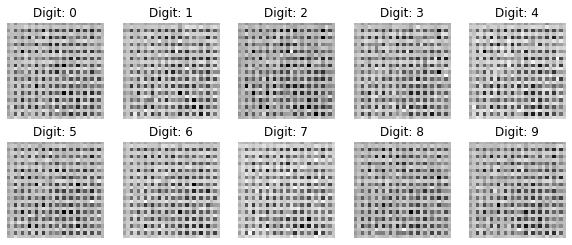

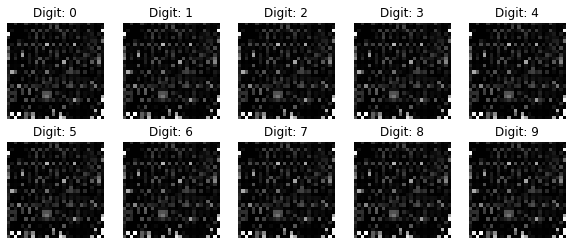

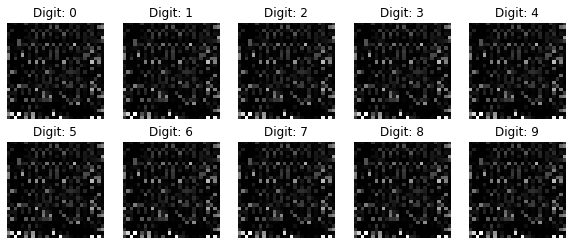

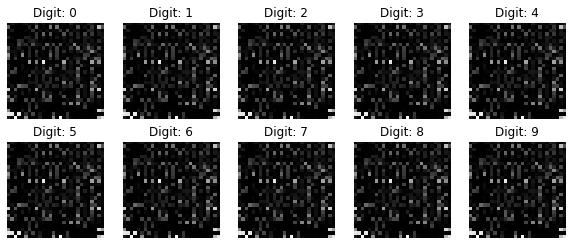

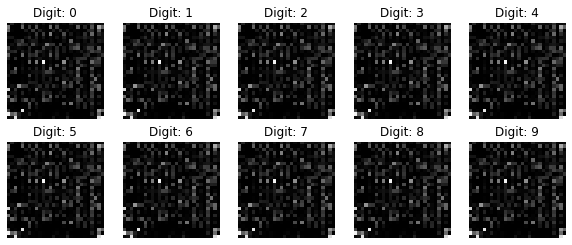

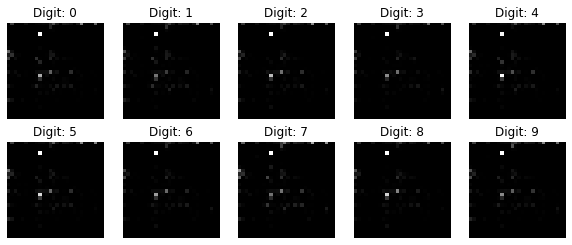

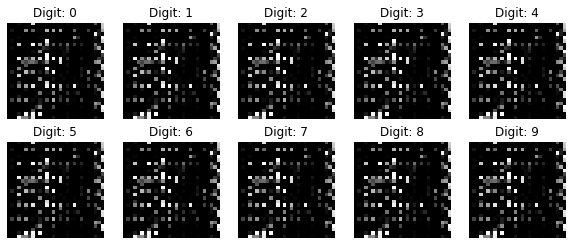

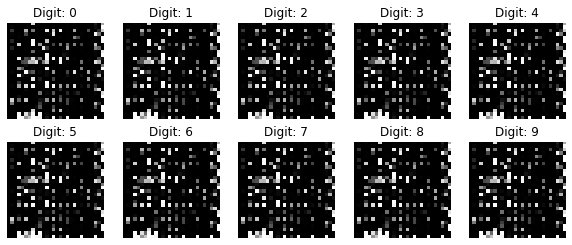

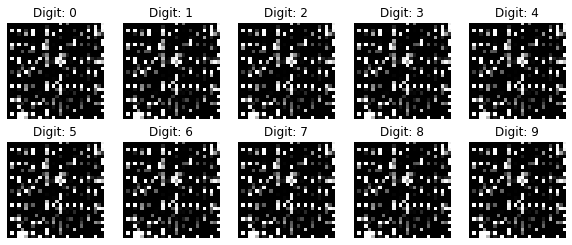

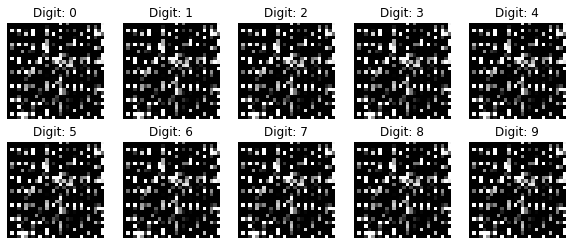

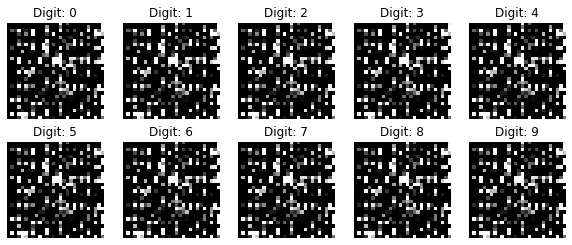

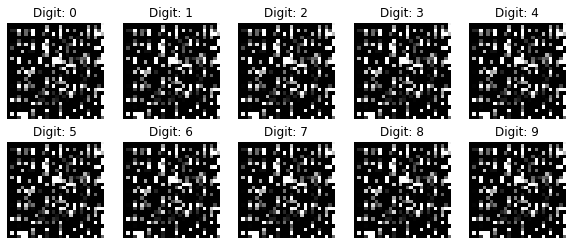

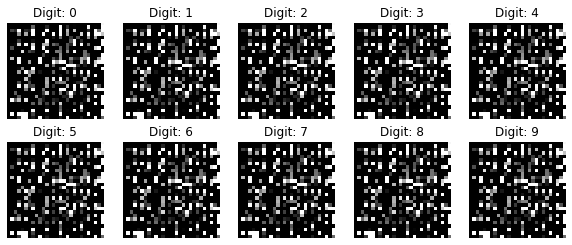

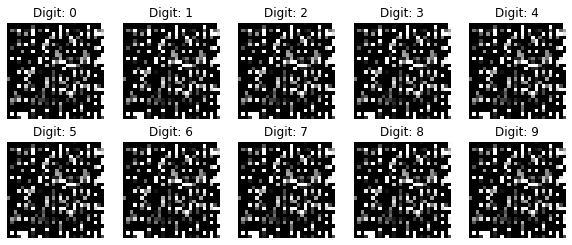

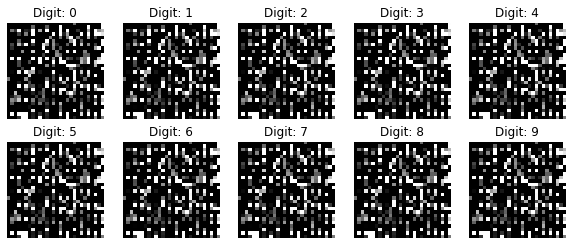

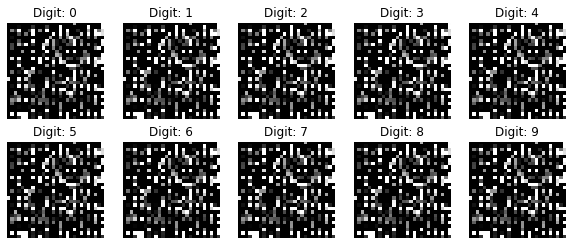

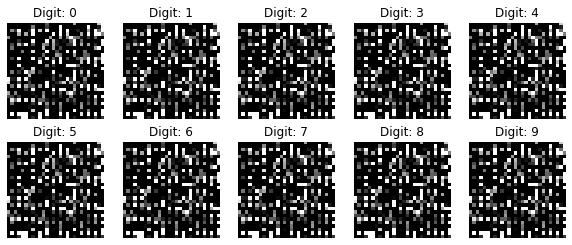

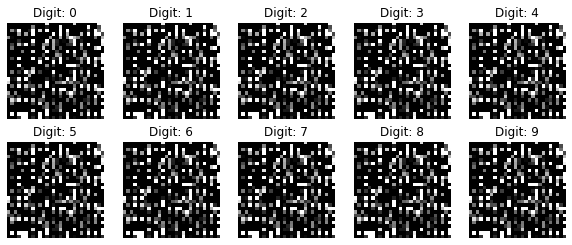

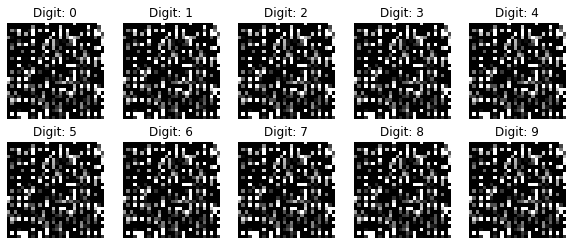

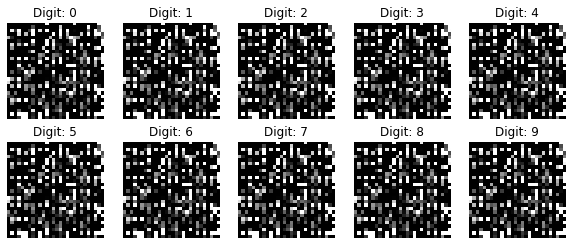

In [14]:
iterations = 20000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)
